In [1]:
# This notebook is used for testing learning in single units
# using the sirasi module
from sirasi import *
import numpy as np
import pylab
import matplotlib 
import time

#matplotlib.use('GTK3Cairo',warn=False, force=True)
from matplotlib import pyplot as plt

In [2]:
def conn_mat(net):
    # Get the connection matrix of a network in a Numpy array
    conns = np.zeros((net.n_units,net.n_units))
    for syn_list in net.syns:
        for syn in syn_list:
            conns[syn.postID,syn.preID] = syn.w
    return conns

def plot_stuff(data, fig):
    fig.clf()
    plt.close()
    fig = plt.figure(figsize=(10,10))
    for i in range(9):
        ax = fig.add_subplot(3,3,i+1)
        ax.clear()
        plt.ylim(-0.01,0.5)
        ax.plot(data[0], data[1][i], 'r', figure=fig)
    fig.canvas.draw()
    plt.show()
    

In [3]:
#matplotlib.use('GTK3Agg',warn=False, force=True)
#from matplotlib import pyplot as plt
################# TEST 1 ####################
######### 1) Create a network
net_params = {'min_delay' : 0.1, 'min_buff_size' : 4 } # parameter dictionary for the network
n1 = network(net_params)

######### 2) Put some units in the network
# default parameters for the units
pars = { 'coordinates' : [[0., 0., 0.]],
         'delay' : 1., 'init_val' : 0.5, 'tau_fast' : 1.,
         'slope' : 1., 'thresh' : 0.0, 'tau' : 0.02,
         'type' : unit_types.source } 
inputs = n1.create(9,pars) # creating nine input sources
pars['type'] = unit_types.linear
unit = n1.create(1,pars) # creating one linear unit

######### 3) Connect the units in the network
conn_spec = {'rule' : 'all_to_all', 'delay' : 1.,
             'allow_autapses' : False} # connection specification dictionary
syn_pars = {'init_w' : 0.2, 'lrate' : 0.01, 
            'type' : synapse_types.oja} # synapse parameters dictionary
n1.connect(inputs, unit, conn_spec, syn_pars)

######### 4) Running and visualizing 

####### SETTING THE INPUT FUNCTIONS
### You are going to present 4 input patterns that randomly switch over time.
### Imagine the 9 inputs arranged in a grid, like a tic-tac-toe board, numbered
### from left to right and from top to bottom:
### 1 2 3
### 4 5 6
### 7 8 9
### You'll have input patterns
### 0 X 0   0 0 0   X 0 X   0 X 0
### 0 X 0   X X X   0 0 0   X 0 X
### 0 X 0   0 0 0   X 0 X   0 X 0
### The input is always a normalized linear combination of one or two of these patterns.
### Pattern pat1 is presented alone for t_pat time units, and then there is a transition period
### during which pat1 becomes pat2 by presenting at time t an input 
### c*(t_pat+t_trans - t)*pat1 + c*(t - tpat)*pat2
### where c = 1/t_trans, and t_trans is the duration of the transition period. 
### At time t_pat+t_trans, pat2 is presented by itself for t_pat time units.
### 
# here are the patterns as arrays
patterns = [np.zeros(9) for i in range(4)]
patterns[0] = np.array([0., 1., 0., 0., 1., 0., 0., 1., 0.])/3.
patterns[1] = np.array([0., 0., 0., 1., 1., 1., 0., 0., 0.])/3.
patterns[2] = np.array([1., 0., 1., 0., 0., 0., 1., 0., 1.])/4.
patterns[3] = np.array([0., 1., 0., 1., 0., 1., 0., 1., 0.])/4.

n_pres = 100  # number of times some pattern will be presented
t_pat = 10.
t_trans = 4.
c = 1/t_trans # auxiliary variable
pats = range(4) # auxiliary variable
cur_pat = np.random.choice(pats)  # pattern currently presented
next_pat = np.random.choice(pats) # next pattern to be presented
last_t = 0.

start_time = time.time()

def make_fun1(idx):  
    # This creates a constant function with value: patterns[cur_pat][idx]
    # thus avoiding a scoping problem that is sometimes hard to see:
    # https://eev.ee/blog/2011/04/24/gotcha-python-scoping-closures/
    fun = lambda t : patterns[cur_pat][idx]
    return fun

def make_fun2(idx, last_t):
    # Creates a function for the pattern transition
    fun = lambda t : c * ( (t_trans - (t-last_t))*patterns[cur_pat][idx] +
                           (t-last_t)*patterns[next_pat][idx] )
    return fun

#fig = plt.figure(figsize=(10,10))
#plt.ion()  # interactive mode for matplotlib
#fig.show()

fig = plt.figure(figsize=(10,10))
#plt.plot([1.5,2.0,2.5])
plt.ion()
#fig = plt.gcf()
#fig.suptitle('t')
#plt.show()

for pres in range(n_pres):
# For each cycle you'll set the input functions and simulate, once with a single pattern,
# once with a mix of patterns, as described above
    # first, we present a single pattern
    for u in range(9):
        n1.units[inputs[u]].set_function( make_fun1(u) )
        
    sim_dat = n1.run(t_pat)  # simulating
    last_t = n1.sim_time # simulation time after last pattern presentation
    
    #plot_stuff(sim_dat,fig)
    #input('Fixed pattern presented: ' + str(cur_pat))
    
    # now one pattern turns into the next
    for u in range(9):
        n1.units[inputs[u]].set_function(make_fun2(u, last_t))
    
    sim_dat = n1.run(t_trans) # simulating
    
    #plot_stuff(sim_dat,fig)
    #plt.show()
    #input('Transitioned to pattern: ' + str(next_pat))

    cur_pat = next_pat
    next_pat = np.random.choice(pats)

print('Execution time: %s seconds' % (time.time() - start_time))



Execution time: 9.197624683380127 seconds


[ 0.45823684  0.81382744  0.45823684  0.95177385  1.          0.95177385
  0.45823684  0.81382744  0.45823684]


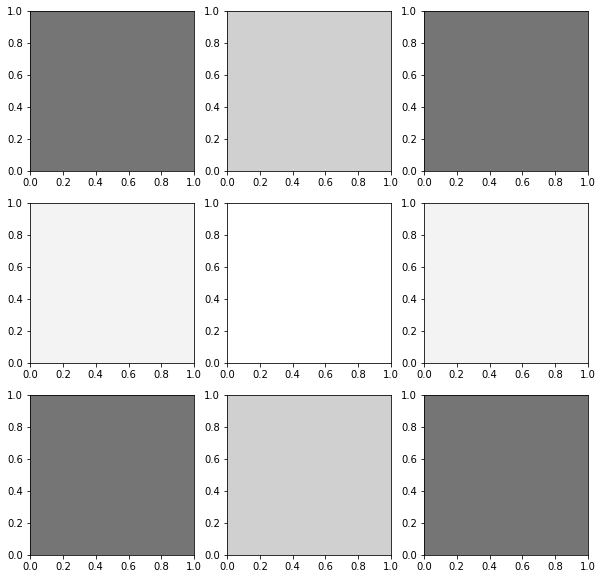

In [4]:
weights = n1.units[9].get_weights(n1.sim_time)
weights = weights/max(weights)
print(weights)
fig2 = plt.figure(figsize=(10,10))
for axi in range(9):
    ax = fig2.add_subplot(3,3,axi+1)
    rect = ax.patch
    rect.set_facecolor(str(weights[axi]))
        
plt.show()

In [18]:
corr = np.zeros((9,9))
for pat in patterns:
    p = pat.reshape(9,1)
    corr += p*(p.T)
eigs = np.linalg.eig(corr)
eigs

(array([  0.00000000e+00,   2.50000000e-01,   6.02188330e-01,
          2.22222222e-01,   5.86369736e-17,   9.22561146e-02,
          3.38581565e-18,   1.84313322e-32,  -2.80417562e-35]),
 array([[ -8.66025404e-01,   5.00000000e-01,  -3.08761480e-17,
           4.89141962e-16,  -3.36062596e-02,  -5.05578278e-17,
          -1.35584396e-01,   8.66025404e-01,   8.66025404e-01],
        [ -0.00000000e+00,   0.00000000e+00,  -4.31604744e-01,
          -5.00000000e-01,   7.06574185e-01,   2.52422949e-01,
           1.64603498e-01,  -5.72339078e-15,   8.70766840e-18],
        [  2.88675135e-01,   5.00000000e-01,  -8.95599013e-17,
           5.89891521e-16,   1.12020865e-02,  -5.41164270e-18,
           4.51947988e-02,  -2.88675135e-01,  -2.88675135e-01],
        [  0.00000000e+00,   0.00000000e+00,  -4.31604744e-01,
           5.00000000e-01,  -2.52583473e-16,   2.52422949e-01,
           6.78712214e-01,  -3.35531982e-27,   2.23373623e-30],
        [  0.00000000e+00,   0.00000000e+00,  -5.048